# STK9900: Mandatory assignment 1

#### Viktor Ananiev

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Problem 1

In [2]:
# reading data

no2 = pd.read_csv("data/no2.txt", sep="\t")
no2.columns = [c.replace(".", "_") for c in no2.columns]

**a)** Main features of the dataset

In [3]:
no2.describe()

,log_no2,log_cars,temp,wind_speed,hour_of_day
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,3.698368,6.973342,0.847400,3.056000,12.382000
std,0.750597,1.087166,6.524636,1.784172,6.802693
min,1.223780,4.127130,-18.600000,0.300000,1.000000
25%,3.213863,6.175842,-3.900000,1.675000,6.000000
50%,3.848020,7.425360,1.100000,2.800000,12.500000
75%,4.216930,7.793175,4.900000,4.200000,18.000000
max,6.395090,8.348540,21.100000,9.900000,24.000000


Scatter plot of log_no2(log_cars)

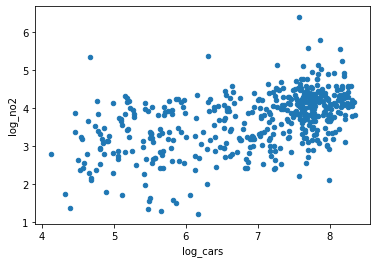

In [4]:
no2.plot.scatter(x="log_cars", y="log_no2")

It seems from the plot that NO2 pollution has some positive correlation with number of cars. Let's construct a linear model to verify this

**b)** We will use statsmodels package to build simple linear regression model for log_no2(log_cars)

In [5]:
no2_lm = ols('log_no2 ~ log_cars', data=no2).fit()
no2_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_no2   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     177.0
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           9.09e-35
Time:                        14:22:34   Log-Likelihood:                -489.51
No. Observations:                 500   AIC:                             983.0
Df Residuals:                     498   BIC:                             991.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2331      0.188      6.575      0.000       0.865       1.602
log_cars       0.3535      0.027     13.303      0.000       0.301       0.406
==============================================================================
Omnibus:                       15.006   Durbin-Watson:                   2.315
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.390
Skew:                          -0.209   Prob(JB):                     5.06e-06
Kurtosis:                       3.998   Cond. No.                         46.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**

We can interpret `Intercept` as a logarithm of the emisson of 1 car, since $log 1 = 0$.

Then no2 level is a power function of number of cars $no2 = e^{Intercept} \times cars^{\beta_{log\_cars}}$. Our model assumes that no2 level is a collective affect, one can think of it as $no2 \propto (1 + 1 + 1 + ... + 1)^{\beta} = (1 + (N-1))^\beta \propto (N-1)^{\beta} \cdot (1 + \frac{\beta}{N-1}) \approx (N - 1)^\beta + \frac{\beta}{N-1} (N-1)^{\beta} = NO2_{N-1} + \beta \cdot \frac{NO2_{N-1}}{N-1}$.

As a result we see that in the large $N$ approximation, we have amount of no2 produced by $N-1$ car, and no2 contributed by $N$th car is actually amount of $N-1$ contribution divided by $N-1$ = mean. Essential thing is that, actually, additional car brings current average emission multipled by factor $\beta$. When $\beta < 1$ it means that next car will bring less and less then average, meaning its contribution less and less important with $N$. At the same time, for $\beta > 1$, which is our case, every consequent car brings a bit more than current average. 

The reason for such a collective effect may be the formation of traffic jams when there are more cars appearing on the streets, then driver should switch engine on/off a lot of times and cause an additional outburst of no2. The more cars coming, the more severe is the trafic jam. As a result, next car brings not average but a bit more, because all cars in the jam become affected

In [6]:
no2_lm.pvalues

Intercept    1.232286e-10
log_cars     9.093857e-35
dtype: float64

From $p$-values it follows that both `Intercept` and $\beta_{log\_cars}$ are significant features and both have enough evidence to reject their null values. At the same time, small $R^2$ means that although we caught some trends with high significance, we still didn't manage to catch 80% of variation in data. Sometimes inclusion of additional features helps

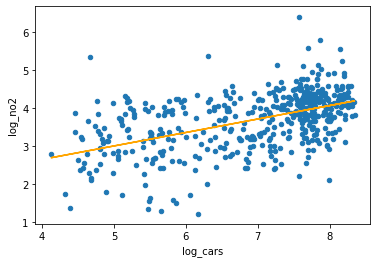

In [7]:
no2.plot.scatter(x="log_cars", y="log_no2")
plt.plot(no2["log_cars"], no2_lm.predict(no2[["log_cars"]]), color="orange")

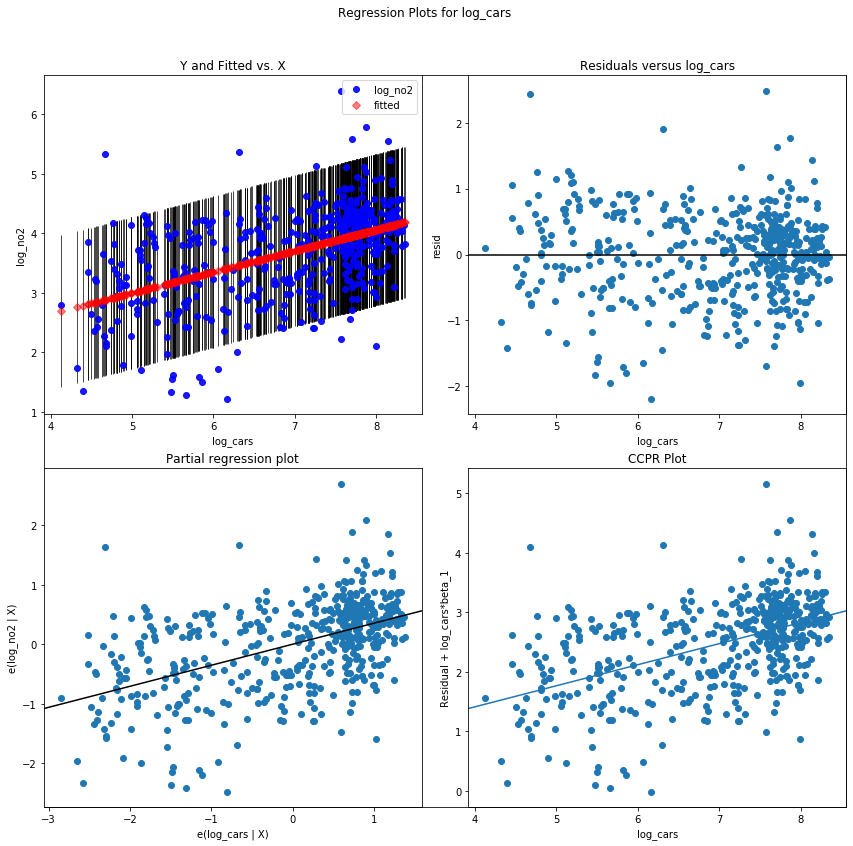

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xticks([])
ax.set_yticks([])
sm.graphics.plot_regress_exog(no2_lm, "log_cars", fig=fig);

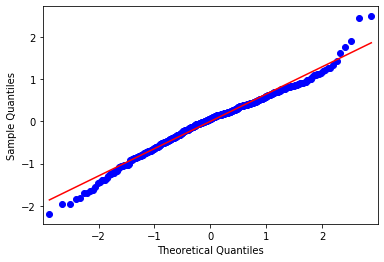

In [14]:
sm.qqplot(no2_lm.resid, line="r");

**c)** From the plots above (which shows both data and fitted linear regression model) we can conclude that we have more data for larger number of cars, meaning our dataset is not balanced in terms of `log_cars`. Thus, slope of the model is determined more by the situation at higher number of cars and consequently this affects the intercept and introduces bias at smaller number of cars. Dropout of data points or giving lower weights to points at higher values of `log_cars` might help to normalize the trend. Whether this helps or no we can check by collecting a test dataset or by using cross-validation technique by splitting original dataset into training and testing.

From the Q-Q plot one can notice that data doesn't behave linearly at the tails, meaning too many and too few cars behave "unpredictably", or not straightforward in comparison to intermediate numbers. They indeed don't fit our model of "jam interaction" because when there is too few cars, $N$ is small and $\beta$ looses its meaning, also for too many cars we have some extreme effects when an extra car brings much more NO2 then one under intermediate conditions. Might be due to increased traffic accidents or irresolvable situations on the roads, when there are many cars there. 

d) Let's add other features and fit linear regression model for multiple parameters

In [284]:
no2_lm_multi = ols("log_no2 ~ log_cars + temp + wind_speed + hour_of_day", data=no2).fit()
no2_lm_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_no2   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     107.9
Date:                Mon, 24 Feb 2020   Prob (F-statistic):           4.62e-66
Time:                        14:11:03   Log-Likelihood:                -408.76
No. Observations:                 500   AIC:                             827.5
Df Residuals:                     495   BIC:                             848.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1521      0.175      6.582      0.000       0.808       1.496
log_cars        0.4570      0.028     16.084      0.000       0.401       0.513
temp           -0.0269      0.004     -6.877      0.000      -0.035      -0.019
wind_speed     -0.1493      0.014    -10.609      0.000      -0.177      -0.122
hour_of_day    -0.0130      0.004     -2.926      0.004      -0.022      -0.004
==============================================================================
Omnibus:                       19.075   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.623
Skew:                          -0.294   Prob(JB):                     3.69e-07
Kurtosis:                       4.037   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [285]:
no2_lm_multi.pvalues

Intercept      1.185898e-10
log_cars       3.907680e-47
temp           1.852025e-11
wind_speed     7.859736e-24
hour_of_day    3.595011e-03
dtype: float64

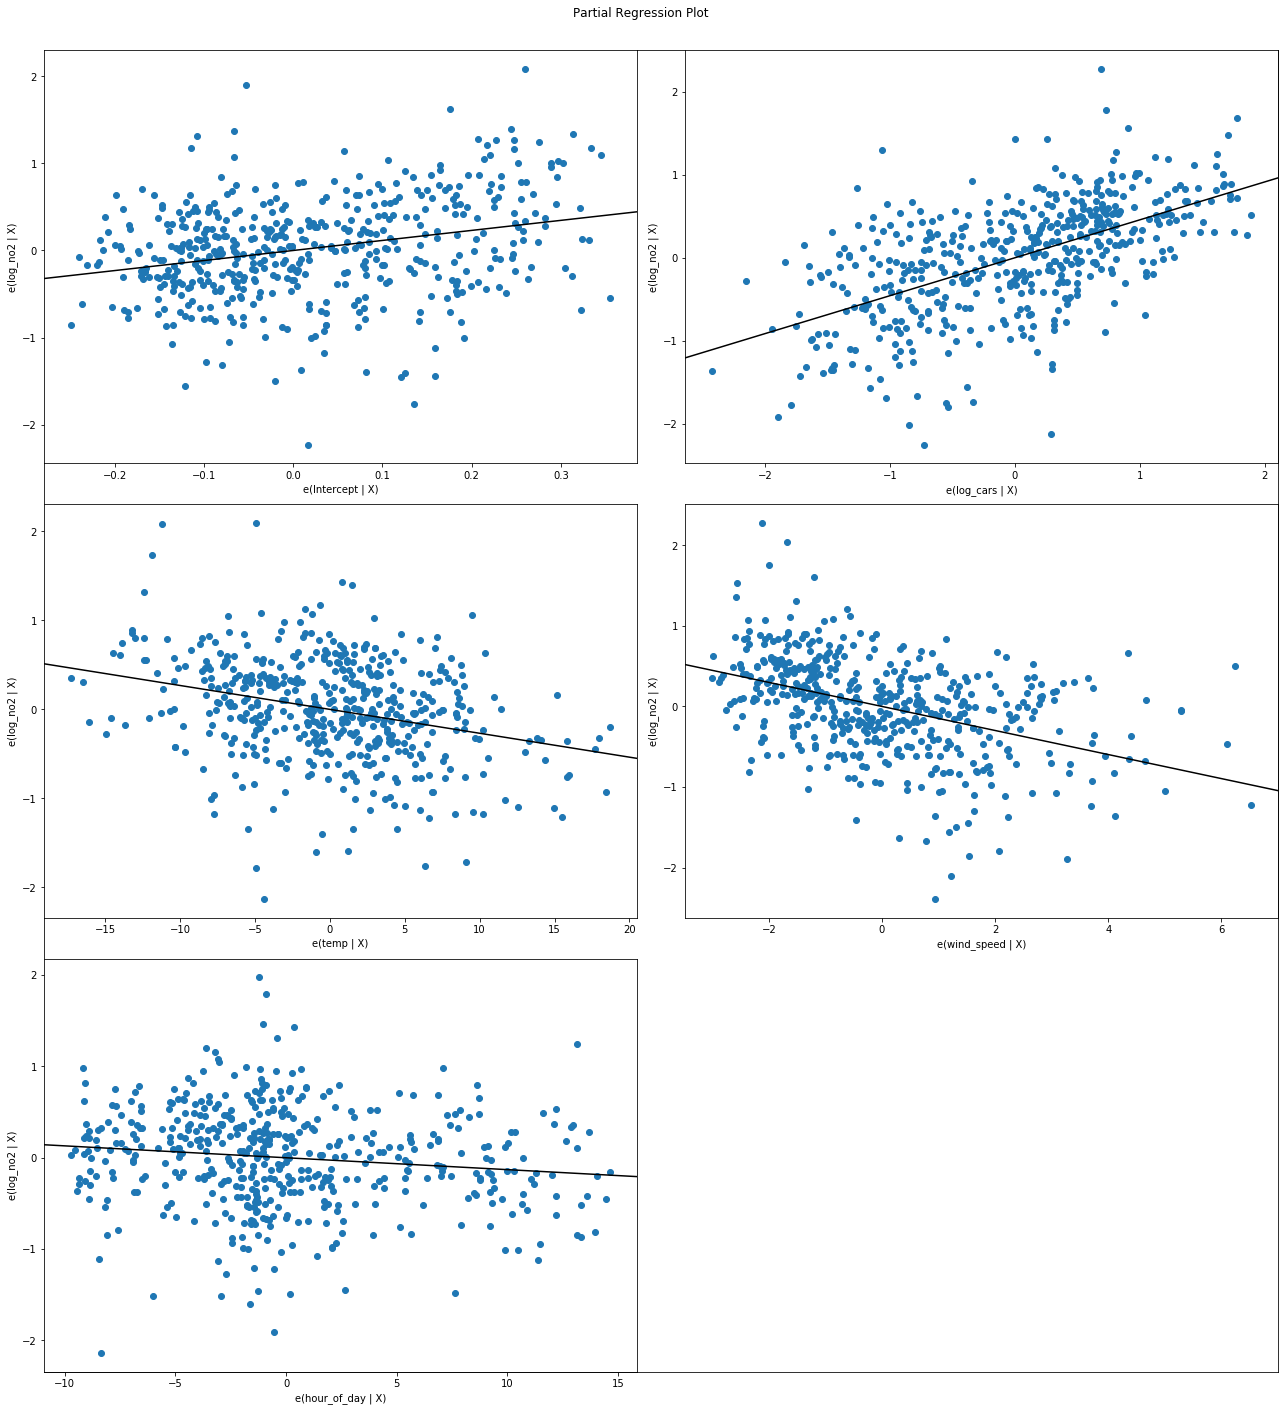

In [366]:
# partial regression plots. How log_no2 changes as a function of different features. Linear trend fitted on top.

fig, ax = plt.subplots(figsize=(18,20))
ax.set_xticks([])
ax.set_yticks([])
sm.graphics.plot_partregress_grid(no2_lm_multi, fig=fig);

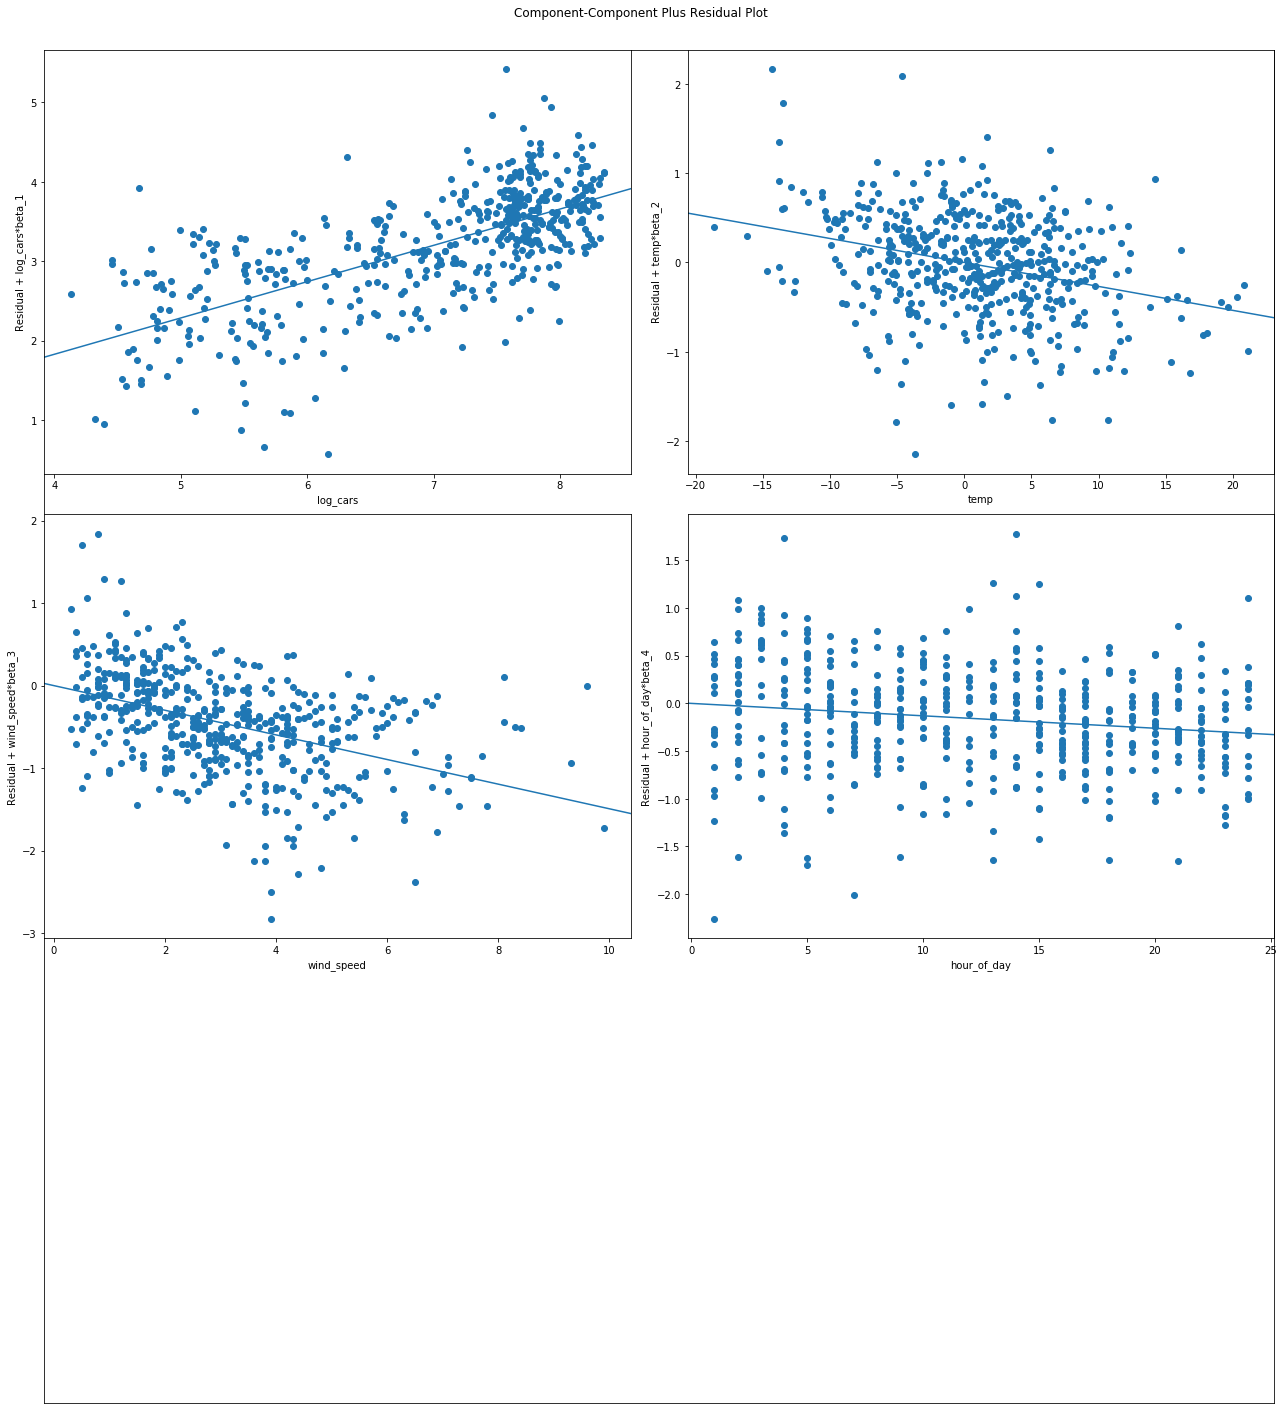

In [286]:
fig, ax = plt.subplots(figsize=(18,20))
ax.set_xticks([])
ax.set_yticks([])
sm.graphics.plot_ccpr_grid(no2_lm_multi, fig=fig);

It follows from the ccpr plots above, that `log_cars` and `wind_speed` have homoscedastic behavior which perfectly fits into assumptions of linear regression model. At the same time, `temp` residuals have a kind of round shape, meaning this feature is not normally variated around the trend line. Finally, `hour_of_dat` shows some changing pattern, variation decreases from 0 to 15 and then increases until 24. In general, its variation is not too large, so maybe we could keep it unchanged.

**d) + e)** Now we will apply transformations to `temp` and `hour_of_day`.

$temp^\prime = (temp < 0)$ — after playing with the data, it turned out that sign of the temperature plays a significant role in determination of no2 emissions. So instead of trying to unfold the tails I suggest to focus on the sign of the temperature. This might be motivated by the ability of warm no2 to be transported by wind, also it might stays higher in the atmosphere then. But definitely this assumption should be checked with further studies.

$hour\_of\_day^\prime = (hour\_of\_day < 15)$ — `hour_of_day` became another categorical variable, since we discovered that behavior of variance shape switches at 15 o'clock. Specific hour of day doesn't seem to be important, maybe because traffic jam is a long process which lasts from the generation to the dilution of the jam, which lasts several hours (~4). Finally, character of the jam differs whether it is morning jam or evening jam, that's how variation behavior might be affected.


In [363]:
no2_lm_multi_mod = ols("log_no2 ~ log_cars + C(temp_m) + wind_speed + C(hour_of_day_m)", data=no2.assign(temp_m=(no2.temp < 0), hour_of_day_m=(no2.hour_of_day.values < 15))).fit()
no2_lm_multi_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_no2   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     99.82
Date:                Mon, 24 Feb 2020   Prob (F-statistic):           2.97e-62
Time:                        15:55:06   Log-Likelihood:                -417.66
No. Observations:                 500   AIC:                             845.3
Df Residuals:                     495   BIC:                             866.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.9956      0.202      4.935      0.000       0.599       1.392
C(temp_m)[T.True]            0.2684      0.052      5.211      0.000       0.167       0.370
C(hour_of_day_m)[T.True]     0.1681      0.056      2.985      0.003       0.057       0.279
log_cars                     0.4251      0.026     16.459      0.000       0.374       0.476
wind_speed                  -0.1550      0.014    -10.830      0.000      -0.183      -0.127
==============================================================================
Omnibus:                       19.141   Durbin-Watson:                   2.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.657
Skew:                          -0.296   Prob(JB):                     3.63e-07
Kurtosis:                       4.036   Cond. No.                         64.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [364]:
no2_lm_multi_mod.pvalues

Intercept                   1.095589e-06
C(temp_m)[T.True]           2.756801e-07
C(hour_of_day_m)[T.True]    2.973657e-03
log_cars                    7.228344e-49
wind_speed                  1.133639e-24
dtype: float64

While significance of temperature variable decreased a bit, it is still at the discovery level. Moreover we increased significance of `hour_of_day` by translating it into categorical variable.

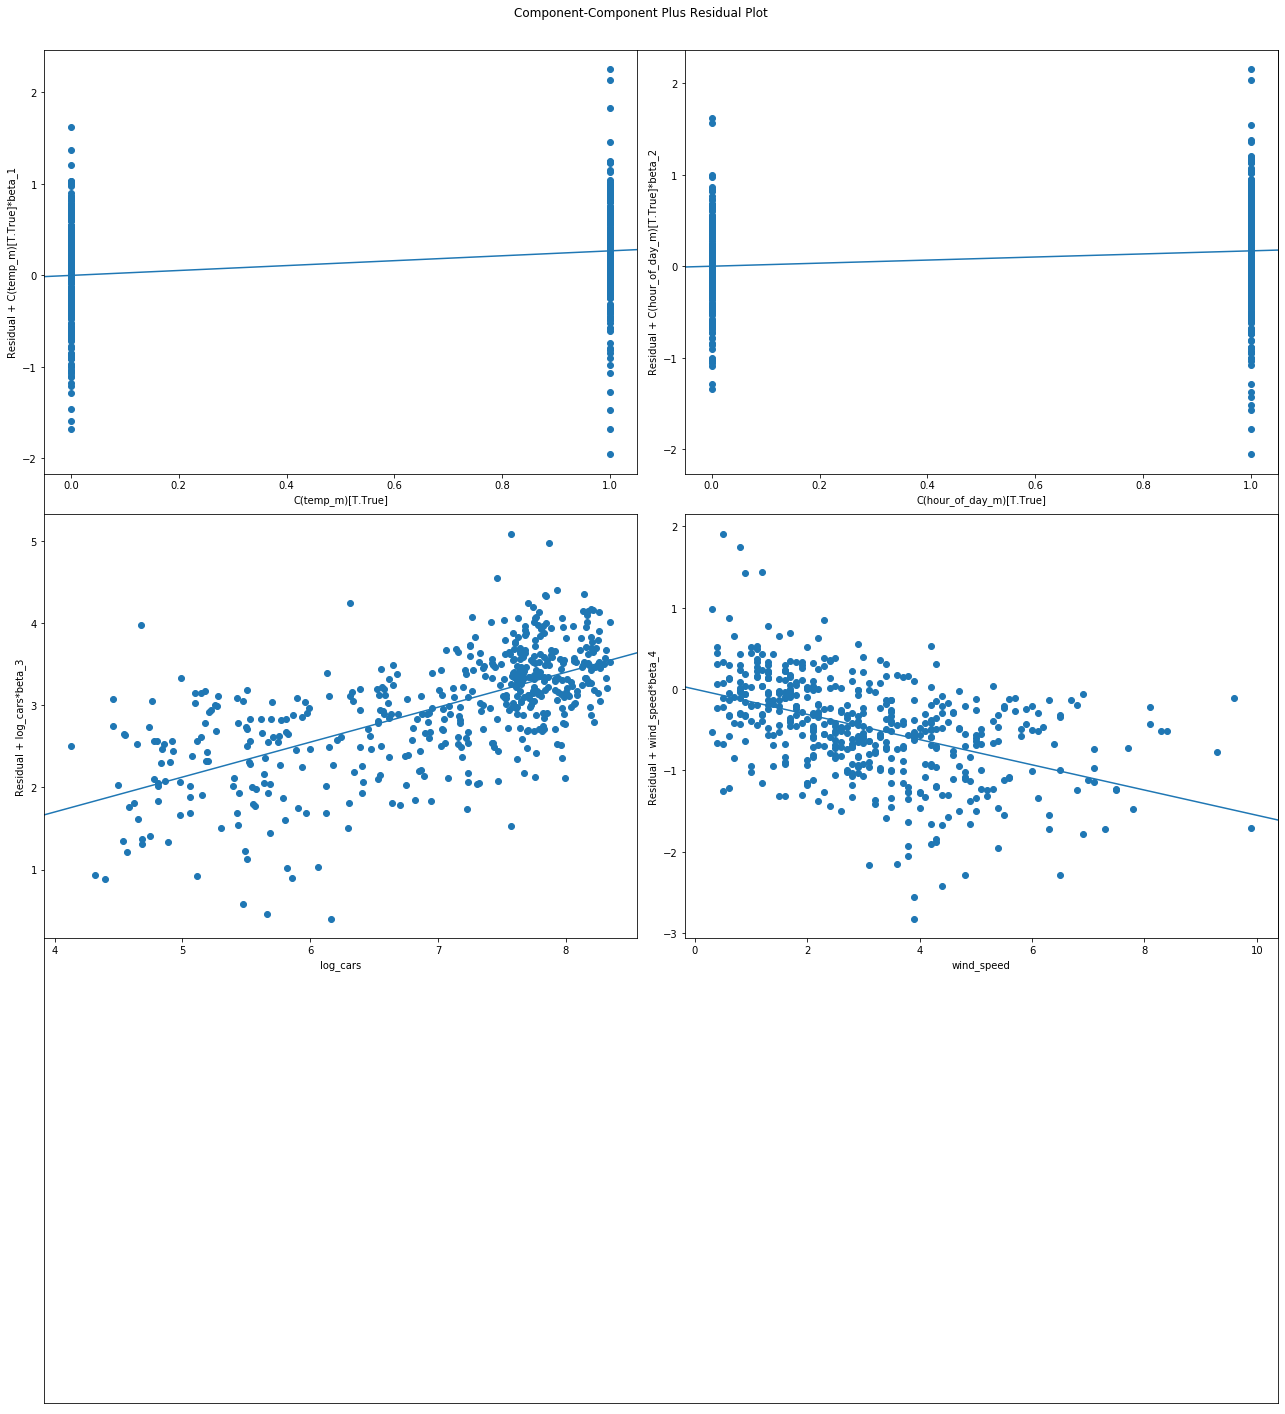

In [365]:
fig, ax = plt.subplots(figsize=(18,20))
ax.set_xticks([])
ax.set_yticks([])
sm.graphics.plot_ccpr_grid(no2_lm_multi_mod, fig=fig);

Finally, the $R^2$ has decreased a bit in comparison to straightaway applied multiparametric regression, however it doesn't mean the model became worse. There is usual trade-off between variance and bias, and here by increasing variance (decreasing $R^2$) we expect to have reduced bias, thus better predictive power.

# Problem 2

In [388]:
blood = pd.read_csv("data/blood.txt", sep=" ")
blood.groupby(["age"]).describe()

Bloodpr                                                           
      count        mean        std    min    25%    50%     75%    max
age                                                                   
1      12.0  122.166667  15.337615  104.0  112.0  117.0  129.00  160.0
2      12.0  139.083333  22.625241  108.0  121.5  137.0  157.75  174.0
3      12.0  155.166667  27.718826  110.0  138.0  148.0  164.00  214.0

In [404]:
# find counts of values in different groups
blood.age.value_counts()

3    12
2    12
1    12
Name: age, dtype: int64

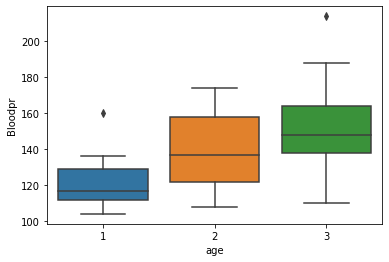

In [378]:
sns.boxplot(x="age", y="Bloodpr", data=blood)

**a)** From the box plots it seems that blood pressure depends on the age group, however error bars grow with age group, so I guess group 1 has more significant difference from 2 and 3, while 2 and 3 might be comparably similar due to error bars. With ANOVA test we can only check whether there is a "black sheep", but we can't say which group is it, thus it is impossible to test my guess in the ANOVA setting.

**b)** let's use one way ANOVA to test whether there is significant difference between blood pressure values for different groups

In [409]:
lm = ols("Bloodpr ~ C(age, Treatment)", data=blood).fit()

In [410]:
# we use type=1 ANOVA, which applies sequential analysis of groups. This type of analysis suits our data, since it is balanced
aov = sm.stats.anova_lm(lm, typ=1); aov

,df,sum_sq,mean_sq,F,PR(>F)
"C(age, Treatment)",2.0,6535.388889,3267.694444,6.468644,0.004263
Residual,33.0,16670.250000,505.159091,NaN,NaN


from the ANOVA table above we can conclude that even under 99% confidence level we still can reject null hypothesis, claiming that there is significant difference between blood pressure values of different age groups

**c)** let's now apply linear regression method in order to test whether group 2 or group 3 significantly differs from group 1 by treating group 1 as a reference

In [412]:
# linear regression is conducted with categorical variables taken according to their order, thus age = 1 is taken as a baseline
# moreover, contrast-Treatment was used as a coding method: https://www.statsmodels.org/stable/contrasts.html?highlight=categorical
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Bloodpr   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     6.469
Date:                Mon, 24 Feb 2020   Prob (F-statistic):            0.00426
Time:                        18:14:41   Log-Likelihood:                -161.56
No. Observations:                  36   AIC:                             329.1
Df Residuals:                      33   BIC:                             333.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                122.1667      6.488     18.829      0.000     108.966     135.367
C(age, Treatment)[T.2]    16.9167      9.176      1.844      0.074      -1.751      35.585
C(age, Treatment)[T.3]    33.0000      9.176      3.596      0.001      14.332      51.668
==============================================================================
Omnibus:                        2.917   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.005
Skew:                           0.570   Prob(JB):                        0.367
Kurtosis:                       3.198   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

first of all, we've got more detailed table then the one from ANOVA. here we have significance of each of two groups in comparison to the reference.

specifying group 1 as a reference we test for hypothesis: whether group 2 is significantly different from group 1, and whether group 3 is significantly different from group 1. From the linear regression table we see that under 99% confidence level group 3 is different from 1, but for group 2 it is not enough evidence to reject null hypothesis, its P-value is too big.

my guess about 1 vs 2 and 3 was not confirmed totally, since there was not enough evidence to reject null hypothesis for 1 vs 2, but 1 vs 3 has been confirmed. Also, as a next step it would be reasonable to check how different are 2 and 3, but I wouldn't expect enough evidence there.